<p style="font-family: 'Times New Roman', Times, serif; font-size:24px; color: black;">This file generates all figures and displays all results reported in the paper.</p>

In [1]:
import os
import pickle as pkl
import json
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
from matplotlib.cm import ScalarMappable
import seaborn as sns
from collections import defaultdict
from config import *

In [2]:
os.makedirs(figures_rootdir, exist_ok=True)

In [3]:
font_size = 9
font_name = 'Times New Roman'
font_dict = {'family': font_name, 'size': font_size}
plt.rcParams['font.size'] = font_size
plt.rcParams['font.family'] = font_name

In [4]:
dfs = []
for user_id in user_id_list:
    df_reaction = pd.read_csv(os.path.join(prep_rootdir, 'preprocessed_reaction_data', f"{user_id}.csv"))
    df_images = pd.read_csv(os.path.join(prep_rootdir, 'preprocessed_image_data', f"{user_id}.csv"))
    df = pd.merge(df_reaction, df_images, on = ['session_index', 'image_index'], how='inner')
    df['user_id'] = user_id
    dfs.append(df)
df_reaction = pd.concat(dfs)

<ipython-input-4-63247009c480>:8: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df_reaction = pd.concat(dfs)


<p style="font-family: 'Times New Roman', Times, serif; font-size:24px; color: black;">6.1 Statistical Analysis</p>

In [5]:
p_threshold = 0.05 / (12*8)

In [6]:
rating = 'overall_rating'
df_reaction_filtered = df_reaction[df_reaction[rating] > 0].copy()
df_reaction_filtered[f'{rating}_deviation'] = np.abs(df_reaction_filtered[rating] - 4)
df_ratings = pd.DataFrame({'AU': DISFA_AUs,
                           'rho_sequantial':
                           [stats.spearmanr(df_reaction_filtered[rating],
                                            df_reaction_filtered[f'AU{AU}_activation_value'])[0] for AU in DISFA_AUs],
                           'p_value_sequential':
                           [stats.spearmanr(df_reaction_filtered[rating],
                                            df_reaction_filtered[f'AU{AU}_activation_value'])[1] for AU in DISFA_AUs],
                           'rho_symmetric':
                           [stats.spearmanr(df_reaction_filtered[f'{rating}_deviation'],
                                            df_reaction_filtered[f'AU{AU}_activation_value'])[0] for AU in DISFA_AUs],
                           'p_value_symmetric':
                           [stats.spearmanr(df_reaction_filtered[f'{rating}_deviation'],
                                                df_reaction_filtered[f'AU{AU}_activation_value'])[1] for AU in DISFA_AUs]})
df_ratings = df_ratings.set_index('AU')

In [7]:
df_ratings

,rho_sequantial,p_value_sequential,rho_symmetric,p_value_symmetric
AU,,,,
1,0.064884,2.312202e-03,0.099987,2.574945e-06
2,0.087530,3.890267e-05,0.110589,1.954342e-07
4,-0.177750,4.271928e-17,-0.034339,1.071111e-01
5,-0.040861,5.516557e-02,0.077031,2.959130e-04
6,-0.013997,5.114170e-01,0.064320,2.524922e-03
9,-0.093508,1.102355e-05,0.064120,2.604498e-03
12,0.080999,1.413158e-04,0.142731,1.697354e-11
15,-0.039791,6.185802e-02,-0.014756,4.887846e-01
17,-0.000212,9.920774e-01,0.015411,4.696928e-01


In [8]:
seq_colors = [sns.color_palette("Blues", as_cmap=True)(i) for i in np.linspace(0.8, 0.2, 7)]
sym_colors = [sns.color_palette("YlOrBr", as_cmap=True)(i) for i in [0.8, 0.6, 0.4, 0.2, 0.4, 0.6, 0.8]]
mix_colors = 0.5 * np.flip(np.array(seq_colors), axis=0) + 0.5 * np.array(sym_colors)
mix_colors = list(map(tuple, mix_colors.tolist()))

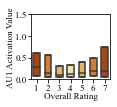

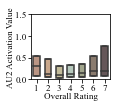

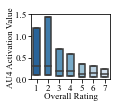

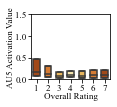

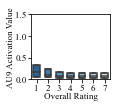

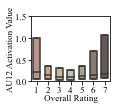

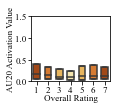

In [9]:
for AU in DISFA_AUs:
    if df_ratings['p_value_sequential'][AU] <= p_threshold or df_ratings['p_value_symmetric'][AU] <= p_threshold:
        if df_ratings['p_value_sequential'][AU] <= p_threshold and df_ratings['p_value_symmetric'][AU] <= p_threshold:
            palette = mix_colors
        elif df_ratings['p_value_sequential'][AU] <= df_ratings['p_value_symmetric'][AU]:
            palette = seq_colors
        else:
            palette = sym_colors
    else:
        continue
    
    plt.figure(figsize = [1.7, 1.5])
    sns.boxplot(data = df_reaction_filtered, x = rating, y = f'AU{AU}_activation_value', width = 0.6, palette=palette, showfliers=False, whis=0)
    plt.tick_params(axis='both', which='major', pad=1)
    plt.xlabel("Overall Rating", labelpad=0)
    plt.ylabel(f"AU{AU} Activation Value", labelpad=0)
    plt.xlim([-0.5, 6.5])
    plt.ylim([0, 1.5])
    plt.yticks([0, 0.5, 1, 1.5])
    plt.tight_layout()
    
    plt.savefig(os.path.join(figures_rootdir, f"overall_rating_and_AU{AU}_activation_value.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

In [10]:
for rating in [1, 2, 3, 4, 5, 6, 7]:
    print(f"Number of ratings of {rating}: {np.sum(df_reaction_filtered['overall_rating'] == rating)}")

Number of ratings of 1: 104
Number of ratings of 2: 185
Number of ratings of 3: 258
Number of ratings of 4: 456
Number of ratings of 5: 581
Number of ratings of 6: 403
Number of ratings of 7: 216


In [11]:
df_emotions_rho = pd.DataFrame({f"{option}_z":
                                [stats.ranksums(df_reaction[df_reaction[option] == True][f'AU{AU}_activation_value'],
                                                df_reaction[df_reaction[option] == False][f'AU{AU}_activation_value'])[0] for AU in DISFA_AUs] for option in reaction_options})
df_emotions_p = pd.DataFrame({f"{option}_p":
                              [stats.ranksums(df_reaction[df_reaction[option] == True][f'AU{AU}_activation_value'],
                                              df_reaction[df_reaction[option] == False][f'AU{AU}_activation_value'])[1] for AU in DISFA_AUs] for option in reaction_options})
df_emotions = pd.concat([df_emotions_rho, df_emotions_p], axis=1)
df_emotions = df_emotions[[s for p in [[f"{option}_z", f"{option}_p"] for option in reaction_options] for s in p]]
df_emotions['AU'] = DISFA_AUs
df_emotions = df_emotions.set_index('AU')

In [12]:
df_emotions

,disappointed_z,disappointed_p,satisfied_z,satisfied_p,surprised_z,surprised_p,disgusted_z,disgusted_p,amused_z,amused_p,scared_z,scared_p
AU,,,,,,,,,,,,
1,-4.253206,2.107315e-05,-1.634018,1.022551e-01,-0.121693,0.903142,1.709416,8.737392e-02,-1.456186,1.453411e-01,1.445043,1.484457e-01
2,-5.823828,5.751487e-09,-1.364081,1.725420e-01,0.462670,0.643601,1.808029,7.060196e-02,-0.532655,5.942721e-01,0.988958,3.226837e-01
4,4.815768,1.466347e-06,-9.070811,1.181345e-19,1.765344,0.077506,8.338158,7.545642e-17,-1.631271,1.028331e-01,5.600945,2.131867e-08
5,-1.491916,1.357211e-01,-6.617325,3.657557e-11,0.036812,0.970635,3.935649,8.297220e-05,-0.852329,3.940316e-01,4.387261,1.147870e-05
6,-1.289209,1.973253e-01,-2.747972,5.996519e-03,2.103461,0.035425,2.538604,1.112956e-02,6.998175,2.593186e-12,0.875714,3.811853e-01
9,1.943151,5.199795e-02,-6.927022,4.297908e-12,3.778477,0.000158,4.866843,1.133948e-06,5.008218,5.493621e-07,2.798154,5.139568e-03
12,-4.863989,1.150434e-06,0.193034,8.469321e-01,4.289125,0.000018,-0.509093,6.106874e-01,9.153541,5.509725e-20,0.044851,9.642259e-01
15,0.323521,7.463007e-01,-1.285764,1.985255e-01,2.837796,0.004543,2.957602,3.100419e-03,2.732250,6.290341e-03,2.761462,5.754315e-03
17,-2.413584,1.579651e-02,0.437148,6.620038e-01,2.846647,0.004418,1.834307,6.660847e-02,2.847279,4.409471e-03,-0.429550,6.675227e-01


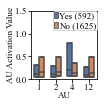

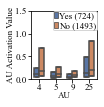

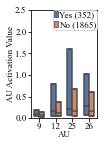

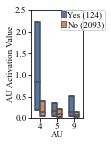

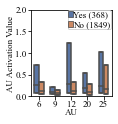

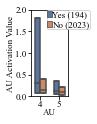

In [13]:
for option_idx, option in enumerate(reaction_options):
    dfs = []
    significant_AUs = df_emotions.index[df_emotions[f"{option}_p"] < p_threshold].to_list()
    for AU in significant_AUs:
        df = pd.DataFrame({option: df_reaction[option], 'increase': df_reaction[f'AU{AU}_activation_value'], 'AU': AU})
        dfs.append(df)
    df_option = pd.concat(dfs)
    n_yes = np.sum(df_reaction[option] == True)
    n_no = np.sum(df_reaction[option] == False)
    df_option.loc[df_option[option] == True, option] = f"Yes ({n_yes})"
    df_option.loc[df_option[option] == False, option] = f"No ({n_no})"

    if option_idx in [0, 1]:
        plt.figure(figsize = [0.2*len(significant_AUs)+0.72, 1.55])
    elif option_idx in [2, 3]:
        plt.figure(figsize = [0.2*len(significant_AUs)+0.72, 2.1])
    elif option_idx in [4, 5]:
        plt.figure(figsize = [0.2*len(significant_AUs)+0.72, 1.8])
    sns.boxplot(data = df_option, x = 'AU', y = 'increase', hue = option, hue_order = [f"Yes ({n_yes})", f"No ({n_no})"], width = 0.6, palette='deep', showfliers=False, whis=0)#, split = True)#, scale='count')
    plt.tick_params(axis='both', which='major', pad=1)
    plt.xlabel(f"AU", labelpad=0)
    plt.ylabel(f"AU Activation Value", labelpad=0)
    if option_idx in [0, 1]:
        plt.ylim([0, 1.5])
        plt.yticks([0, 0.5, 1, 1.5])
    elif option_idx in [2, 3]:
        plt.ylim([0, 2.5])
        plt.yticks([0, 0.5, 1, 1.5, 2, 2.5])
    elif option_idx in [4, 5]:
        plt.ylim([0, 2])
        plt.yticks([0, 0.5, 1, 1.5, 2])
    plt.tight_layout()
    if option_idx in [3, 5]:
        loc = 'upper center'
    else:
        loc = 'upper right'
    plt.legend(loc = loc, handlelength=0.5, handletextpad=0.1, borderpad=0.05, labelspacing=0.2, borderaxespad=0.05,
               bbox_to_anchor = [1, 1])
    plt.savefig(os.path.join(figures_rootdir, f"{option}_and_AU_activation_value.pdf"), format='pdf', bbox_inches='tight')
    plt.show()

<p style="font-family: 'Times New Roman', Times, serif; font-size:24px; color: black;">6.2 Automatic Annotation of User Preferences between Image Pairs Using AU4</p>

In [14]:
df_classification = pd.read_csv(os.path.join(results_rootdir, 'image_preference_binary_classification_based_on_ranking.csv'), dtype={'user_id': str})

In [15]:
summary_row = {}
for col in df_classification:
    if col == 'user_id':
        summary_row[col] = 'All'
    elif col.endswith('correct'):
        summary_row[col] = df_classification[col].sum()
    else:
        summary_row[col] = np.unique(df_classification[col], return_counts=True)[0][np.argmax(np.unique(df_classification[col], return_counts=True)[1])]

In [16]:
df_classification = pd.concat([df_classification, pd.DataFrame([summary_row])], ignore_index=True)

In [17]:
basic_metrics = ['CLIP_score', 'Aesthetic_score', 'BLIP_score', 'ImageReward_score', 'PickScore', 'HPS_V2_score']
baseline_metrics = basic_metrics + ['ensemble_baseline_score']
AUs_sel_metrics = baseline_metrics + ['AUcomb_valence_score']
all_metrics = AUs_sel_metrics + [f'AUcomb_selected_{metric}' for metric in AUs_sel_metrics] + ['ensemble_ImageReward_AUcomb_score', 'ensemble_PickScore_AUcomb_score', 'ensemble_HPS_V2_AUcomb_score', 'ensemble_all_score']

In [18]:
accuracies = {metric: df_classification[f'{metric}_n_correct'].iloc[-1] / (df_classification[f'{metric}_n_correct'].iloc[-1] + df_classification[f'{metric}_n_incorrect'].iloc[-1]) for metric in all_metrics}

In [19]:
accuracies

{'CLIP_score': 0.5749858517260894,
 'Aesthetic_score': 0.499151103565365,
 'BLIP_score': 0.499151103565365,
 'ImageReward_score': 0.6044142614601019,
 'PickScore': 0.6335597057159027,
 'HPS_V2_score': 0.6194114318053198,
 'ensemble_baseline_score': 0.6578947368421053,
 'AUcomb_valence_score': 0.5823429541595926,
 'AUcomb_selected_CLIP_score': 0.5824817518248175,
 'AUcomb_selected_Aesthetic_score': 0.5138686131386861,
 'AUcomb_selected_BLIP_score': 0.4978102189781022,
 'AUcomb_selected_ImageReward_score': 0.621897810218978,
 'AUcomb_selected_PickScore': 0.6131386861313869,
 'AUcomb_selected_HPS_V2_score': 0.6204379562043796,
 'AUcomb_selected_ensemble_baseline_score': 0.6656934306569343,
 'AUcomb_selected_AUcomb_valence_score': 0.727007299270073,
 'ensemble_ImageReward_AUcomb_score': 0.6366723259762309,
 'ensemble_PickScore_AUcomb_score': 0.6542161856253537,
 'ensemble_HPS_V2_AUcomb_score': 0.6553480475382003,
 'ensemble_all_score': 0.6748726655348047}